<a target="_blank" href="https://colab.research.google.com/github/AngelicaCorrales/recommendation_system_H_M/blob/main/KModes_H%26M_recomendations_pipelines.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# **Sistema de recomendación usando K-Modes**

Se quiere elaborar un prototipo de un sistema de recomendación de artículos de H&M basado en contenido y teniendo en cuenta el historial de compras de los clientes. 

#**Descargar datasets desde Kaggle**

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

 **Token 1**

In [ ]:
!cp /content/drive/MyDrive/AI/Proyecto_HM/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/AI/Proyecto_HM/kaggle.json': No such file or directory


**Token 2**

In [ ]:
!cp /content/drive/MyDrive/Proyecto_HM/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f transactions_train.csv

 99% 579M/584M [00:08<00:00, 80.0MB/s]
100% 584M/584M [00:08<00:00, 73.0MB/s]


In [ ]:
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations -f customers.csv

 94% 92.0M/97.9M [00:02<00:00, 52.9MB/s]
100% 97.9M/97.9M [00:02<00:00, 49.0MB/s]


In [ ]:
! kaggle competitions download h-and-m-personalized-fashion-recommendations -f articles.csv

  0% 0.00/4.26M [00:00<?, ?B/s]
100% 4.26M/4.26M [00:00<00:00, 55.7MB/s]


In [ ]:
!unzip transactions_train.csv.zip

Archive:  transactions_train.csv.zip
  inflating: transactions_train.csv  


In [ ]:
!unzip customers.csv.zip

Archive:  customers.csv.zip
  inflating: customers.csv           


In [ ]:
!unzip articles.csv.zip

Archive:  articles.csv.zip
  inflating: articles.csv            


# **Importar librerías necesarias para la exploración**

In [ ]:
#Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


!pip install yellowbrick --upgrade                   #Instala y actualiza la librería yellowbrick (la versión por defecto en Google Colab está desactualizada).
from yellowbrick.cluster import KElbowVisualizer     #Permite obtener la gráfica del codo para tres métricas diferentes (distorsión, silueta, CH).
from yellowbrick.cluster import SilhouetteVisualizer #Permite obtener la gráfica de las siluetas de cada grupo. 
!pip install kmodes
from kmodes.kmodes import KModes

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.metrics import pairwise_distances_argmin_min

# Preprocesado y modelado
# ==============================================================================
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import LabelEncoder

df_articles = pd.read_csv('articles.csv',na_values='?')
df_transactions = pd.read_csv('transactions_train.csv',na_values='?')
df_customers = pd.read_csv('customers.csv',na_values='?')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Organización y limpieza de los datos**

In [ ]:
#Copias de los dataframes originales para su respectiva modificación
df_custClean=df_customers.copy()
df_tranClean=df_transactions.copy()
df_articles_copy=df_articles.copy() 

In [ ]:
pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

In [ ]:
class DropFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
    def fit(self):
        return self
    def transform(self, df):
        df.drop(columns=self.variables, axis=1, inplace=True)
        return df

In [ ]:
class ValueReplacer(BaseEstimator, TransformerMixin):
    def __init__(self, column, currentValues, newValue):
        self.column = column
        self.currentValues = currentValues
        self.newValue = newValue
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].replace(self.currentValues, self.newValue, inplace=True)
        return df

In [ ]:
class DropNaNValues(BaseEstimator, TransformerMixin):
    def fit(self):
        return self
    def transform(self, df):
        df=df.dropna()
        df=df.reset_index(drop=True)
        return df    

In [ ]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    def __init__(self, column, factor=1.5):
        self.factor = factor
        self.column=column
    def fit(self):
        return self
    def transform(self, df):
        q1 = np.quantile(df[self.column].values, 0.25)
        q3 = np.quantile(df[self.column].values, 0.75)
        iqr = q3 - q1
        upper_bound = q3 + (self.factor * iqr)
        lower_bound = q1 - (self.factor * iqr)
        outliers = df[self.column].values[(df[self.column].values <= lower_bound) | (df[self.column].values >= upper_bound)]
        if ((outliers.size*100)/(df[self.column].count()))<10:
            df = df[~df[self.column].isin(outliers)]
            df = df.reset_index(drop=True)
        return df

In [ ]:
class DropDuplicatedValues(BaseEstimator, TransformerMixin):
    def fit(self):
        return self
    def transform(self, df):
        df.drop_duplicates()
        df.reset_index(drop=True)
        return df

In [ ]:
class TypeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, column, newType):
        self.column=column
        self.newType=newType
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].astype(self.newType)
        return df

In [ ]:
class OneHotEncoderWithoutDummiesCustom(BaseEstimator, TransformerMixin):
    def __init__(self,column, ZeroCondition):
        self.column = column
        self.ZeroCondition = ZeroCondition
        self.value= 0
    def fit(self):
        return self
    def transform(self, df):
        df[self.column].replace(self.ZeroCondition, self.value, inplace = True)
        df[self.column].replace(to_replace = r'^(?!'+self.ZeroCondition+').*$', value = 1, regex = True, inplace = True)
        return df

In [ ]:
class LabelEncoderCustom(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables
        
    def fit(self):
        return self
    
    def transform(self, df):
        le = LabelEncoder()
        for i in self.variables:
          df[i] = le.fit_transform(df[i])
        return df

In [ ]:
class transactionsDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropper_duplicate = DropDuplicatedValues()
        self.outlier_remover = OutlierRemover('price')
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropper_duplicate.transform(df)
        df = self.outlier_remover.transform(df)
        return df

In [ ]:
class customerDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropper_column = DropFeatureSelector(['postal_code'])
        self.replace_FN_NaN = ValueReplacer("FN", np.nan,0)
        self.replace_Active_NaN = ValueReplacer("Active", np.nan,0)
        self.replace_member_state = ValueReplacer("club_member_status", ["LEFT CLUB", "PRE-CREATE"], "INACTIVE")
        self.replace_member_state_NaN = ValueReplacer("club_member_status", np.nan,"INACTIVE")
        self.replace_fNews_NONE= ValueReplacer("fashion_news_frequency", "NONE","Never")
        self.replace_fNews_None= ValueReplacer("fashion_news_frequency", "None","Never")
        self.replace_fNews_NaN= ValueReplacer("fashion_news_frequency",np.nan, "Never")
        self.replace_fNews_Monthly= ValueReplacer("fashion_news_frequency","Monthly", "Regularly")
        self.dropperNan = DropNaNValues()
        self.outlier_remover = OutlierRemover('age')
        self.type_converter_Active = TypeConverter('Active','int64')
        self.type_converter_FN = TypeConverter('FN','int64')
        self.oneHot_encoder_mStatus = OneHotEncoderWithoutDummiesCustom("club_member_status","INACTIVE")
        self.oneHot_encoder_fNews = OneHotEncoderWithoutDummiesCustom("fashion_news_frequency","Never")
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropper_column.transform(df)
        df = self.replace_FN_NaN.transform(df)
        df = self.replace_Active_NaN.transform(df)
        df = self.replace_member_state.transform(df)
        df = self.replace_member_state_NaN.transform(df)
        df = self.replace_fNews_NONE.transform(df)
        df = self.replace_fNews_None.transform(df)
        df = self.replace_fNews_NaN.transform(df)
        df = self.replace_fNews_Monthly.transform(df)
        df = self.dropperNan.transform(df)
        df = self.outlier_remover.transform(df)
        df = self.type_converter_Active.transform(df)
        df = self.type_converter_FN.transform(df)
        df = self.oneHot_encoder_mStatus.transform(df)
        df = self.oneHot_encoder_fNews.transform(df)
        return df

In [ ]:
pipeline_customerDatasetCleaning=make_pipeline(
    DropFeatureSelector(['postal_code']),
    ValueReplacer("FN", np.nan,0),
    ValueReplacer("Active", np.nan,0),
    ValueReplacer("club_member_status", ["LEFT CLUB", "PRE-CREATE"], "INACTIVE"),
    ValueReplacer("club_member_status", np.nan,"INACTIVE"),
    ValueReplacer("fashion_news_frequency", "NONE","Never"),
    ValueReplacer("fashion_news_frequency", "None","Never"),
    ValueReplacer("fashion_news_frequency",np.nan, "Never"),
    ValueReplacer("fashion_news_frequency","Monthly", "Regularly"),
    DropNaNValues(),
    OutlierRemover('age'),
    TypeConverter('Active','int64'),
    TypeConverter('FN','int64'),
    OneHotEncoderWithoutDummiesCustom("club_member_status","INACTIVE"),
    OneHotEncoderWithoutDummiesCustom("fashion_news_frequency","Never")
)

In [ ]:
class articlesDatasetCleaning(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.dropperNan = DropNaNValues()
        self.dropperCol= DropFeatureSelector(['product_code','prod_name', 'product_type_no', 'graphical_appearance_no','colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no','index_code','index_group_no','section_no','garment_group_no',"section_name","index_name","department_name","colour_group_name","product_type_name","detail_desc"])
        self.replacerPerceived_colour_value_name =ValueReplacer("perceived_colour_value_name", ['Undefined', 'Unknown'], "Undefined_Unknown"),
        self.replacerUndefined_unknown_metal =ValueReplacer("perceived_colour_master_name", ['undefined', 'Unknown',"Metal"], "undefined-unknown-metal"),
        self.replacerNeutral  =ValueReplacer("perceived_colour_master_name", ['Black', 'White', 'Beige', 'Grey'], "Neutral"),
        self.replacerCool =ValueReplacer("perceived_colour_master_name", ['Blue', 'Lilac Purple', 'Turquoise',  'Green','Bluish Green'], "Cool"),
        self.replacerWarm=ValueReplacer("perceived_colour_master_name", ['Pink', 'Red', 'Mole', 'Orange', 'Brown', 'Yellow','Khaki green', 'Yellowish Green'], "Warm"),
        self.label_encoder = LabelEncoderCustom(['product_group_name', 'graphical_appearance_name', 'perceived_colour_value_name','perceived_colour_master_name','index_group_name','garment_group_name'])
    def fit(self):
        return self
    def transform(self, df):
        df = self.dropperNan.transform(df)
        df = self.dropperCol.transform(df)
        df=self.replacerPerceived_colour_value_name.transform(df)
        df=self.replacerUndefined_unknown_metal.transform(df)
        df=self.replacerNeutral.transform(df)
        df=self.replacerCool.transform(df)
        df=self.replacerWarm.transform(df)
        df = self.label_encoder.transform(df)
        return df

In [ ]:
pipeline_transactionsDatasetCleaning=make_pipeline(
       DropDuplicatedValues(),
       OutlierRemover('price')
)

In [ ]:
pipeline_transactionsDatasetCleaning

Pipeline(steps=[('dropduplicatedvalues', DropDuplicatedValues()),
                ('outlierremover', OutlierRemover(column='price'))])

In [ ]:
pipeline_articlesDatasetCleaning=make_pipeline(
    DropNaNValues(),
    DropFeatureSelector(['product_code','prod_name', 'product_type_no', 'graphical_appearance_no','colour_group_code','perceived_colour_value_id','perceived_colour_master_id','department_no','index_code','index_group_no','section_no','garment_group_no',"section_name","index_name","department_name","colour_group_name","product_type_name","detail_dec"]),
    ValueReplacer("perceived_colour_value_name", ['Undefined', 'Unknown'], "Undefined_Unknown"),
    ValueReplacer("perceived_colour_master_name", ['undefined', 'Unknown',"Metal"], "undefined-unknown-metal"),
    ValueReplacer("perceived_colour_master_name", ['Black', 'White', 'Beige', 'Grey'], "Neutral"),
    ValueReplacer("perceived_colour_master_name", ['Blue', 'Lilac Purple', 'Turquoise',  'Green','Bluish Green'], "Cool"),
    ValueReplacer("perceived_colour_master_name", ['Pink', 'Red', 'Mole', 'Orange', 'Brown', 'Yellow','Khaki green', 'Yellowish Green'], "Warm"),
   
    LabelEncoderCustom(["product_group_name","graphical_appearance_name","perceived_colour_value_name","perceived_colour_master_name","index_group_name","garment_group_name"])
)

In [ ]:
pipeline_articlesDatasetCleaning

Pipeline(steps=[('dropnanvalues', DropNaNValues()),
                ('dropfeatureselector',
                 DropFeatureSelector(variables=['product_code', 'prod_name',
                                                'product_type_no',
                                                'graphical_appearance_no',
                                                'colour_group_code',
                                                'perceived_colour_value_id',
                                                'perceived_colour_master_id',
                                                'department_no', 'index_code',
                                                'index_group_no', 'section_no',
                                                'garment_group_no',
                                                'section_name', 'inde...
                 ValueReplacer(column='perceived_colour_master_name',
                               currentValues=['Pink', 'Red', 'Mole', 'Orange',
                                              'Brown', 'Yellow', 'Khaki green',
                                              'Yellowish Green'],
                               newValue='Warm')),
                ('labelencodercustom',
                 LabelEncoderCustom(variables=['product_group_name',
                                               'graphical_appearance_name',
                                               'perceived_colour_value_name',
                                               'perceived_colour_master_name',
                                               'index_group_name',
                                               'garment_group_name']))])

In [ ]:
pipeline_customerDatasetCleaning

Pipeline(steps=[('dropfeatureselector',
                 DropFeatureSelector(variables=['postal_code'])),
                ('valuereplacer-1',
                 ValueReplacer(column='FN', currentValues=nan, newValue=0)),
                ('valuereplacer-2',
                 ValueReplacer(column='Active', currentValues=nan, newValue=0)),
                ('valuereplacer-3',
                 ValueReplacer(column='club_member_status',
                               currentValues=['LEFT CLUB', 'PRE-CREATE'],
                               newVal...
                 TypeConverter(column='Active', newType='int64')),
                ('typeconverter-2',
                 TypeConverter(column='FN', newType='int64')),
                ('onehotencoderwithoutdummiescustom-1',
                 OneHotEncoderWithoutDummiesCustom(ZeroCondition='INACTIVE',
                                                   column='club_member_status')),
                ('onehotencoderwithoutdummiescustom-2',
                 OneHotEncoderWithoutDummiesCustom(ZeroCondition='Never',
                                                   column='fashion_news_frequency'))])

In [ ]:
df_custClean=pipeline_customerDatasetCleaning.transform(df_custClean)

In [ ]:
df_tranClean=pipeline_transactionsDatasetCleaning.transform(df_tranClean)

In [ ]:
df_articles_copy=pipeline_articlesDatasetCleaning.transform(df_articles_copy)

In [ ]:
df_articles_copy.shape

(105126, 8)

# **Unión de los 3 conjuntos de datos**

In [ ]:
del df_articles
del df_transactions
del df_customers 

In [ ]:
class KeepColumns(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns = columns
    def fit(self, df):
        return self
    def transform(self, df):
        X_new = df[self.columns]
        return X_new

In [ ]:
#creating object of KeepColumns class
keep_columns = KeepColumns(["customer_id"])
keep_columns.get_params()

{'columns': ['customer_id']}

In [ ]:
#Cambio del dataframe de clientes por las columnas a conservar
keep_columns.fit(df_custClean)
df_custClean=keep_columns.transform(df_custClean)


In [ ]:
#creating object of KeepColumns class
keep_columns2 = KeepColumns(["customer_id","article_id"])
keep_columns2.get_params()

{'columns': ['customer_id', 'article_id']}

In [ ]:
#Cambio del dataframe de transacciones por las columnas a conservar
keep_columns2.fit(df_tranClean)
df_tranClean=keep_columns2.transform(df_tranClean)

In [ ]:
class KeepLastRows(BaseEstimator, TransformerMixin):
    def __init__(self,indexMin):
        self.indexMin = indexMin
    def fit(self, df):
        return self
    def transform(self, df):
        X_new = df.iloc[self.indexMin:,:]
        return X_new

In [ ]:
#creating object of KeepLastRows class
keep_rows = KeepLastRows(17000000)
keep_rows.get_params()

{'indexMin': 17000000}

In [ ]:
#Cambio del dataframe de transacciones por las filas a conservar
keep_rows.fit(df_tranClean)
df_tranClean=keep_rows.transform(df_tranClean)


In [ ]:
class MergeDataframes(BaseEstimator, TransformerMixin):
    def __init__(self,on):
        self.on =on
    def fit(self):
        return self
    def transform(self, df1,df2):
        X_merged = pd.merge(df1,df2,on=self.on)
        return X_merged

In [ ]:
#creating object of KeepLastRows class
merge_dfs = MergeDataframes("customer_id")
merge_dfs.get_params()

{'on': 'customer_id'}

In [ ]:
#Union de los dataframes de transacciones y clientes
merge_dfs.fit()
df_merged=merge_dfs.transform(df_tranClean,df_custClean)


In [ ]:
class GetFractionSampleDataframe(BaseEstimator, TransformerMixin):
    def __init__(self,fraction):
        self.fraction = fraction
    def fit(self, df):
        return self
    def transform(self, df):
        X_sample = df.sample(frac=self.fraction)
        return X_sample

In [ ]:
#creating object of GetFractionSampleDataframe class
sample_df = GetFractionSampleDataframe(0.10)
sample_df.get_params()

{'fraction': 0.1}

In [ ]:
#Obtención de una porción del dataframe original
sample_df.fit(df_merged)
df_merged=sample_df.transform(df_merged)


In [ ]:
del df_tranClean
del df_custClean

In [ ]:
#creating object of MergeDataframes class
merge_dfs2 = MergeDataframes("article_id")
merge_dfs2.get_params()

{'on': 'article_id'}

In [ ]:
#Union de los dataframes de merged y articulos
merge_dfs2.fit()
df_merged=merge_dfs2.transform(df_merged,df_articles_copy)


In [ ]:
df_merged.shape

(1315589, 9)

In [ ]:
pipeline_merge=make_pipeline(
    keep_columns,
    keep_columns2,
    keep_rows,
    merge_dfs,
    sample_df ,
    merge_dfs2 
)

In [ ]:
pipeline_merge

Pipeline(steps=[('keepcolumns-1', KeepColumns(columns=['customer_id'])),
                ('keepcolumns-2',
                 KeepColumns(columns=['customer_id', 'article_id'])),
                ('keeplastrows', KeepLastRows(indexMin=17000000)),
                ('mergedataframes-1', MergeDataframes(on='customer_id')),
                ('getfractionsampledataframe',
                 GetFractionSampleDataframe(fraction=0.1)),
                ('mergedataframes-2', MergeDataframes(on='article_id'))])

#**Aplicación de clustering**

##**Estimar el valor de k más óptimo**

In [ ]:
principal_df_articles_cluster=df_articles_copy.copy()
principal_df_articles_cluster.drop(["article_id"], axis=1, inplace=True)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 341929.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 323430.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 315182.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 304849.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 291499.0
Run 1, iteration: 2/100, moves: 5617, cost: 291499.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5326, cost: 282733.0
Run 1, iteration: 2/100, moves: 5589, cost: 282733.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, mov

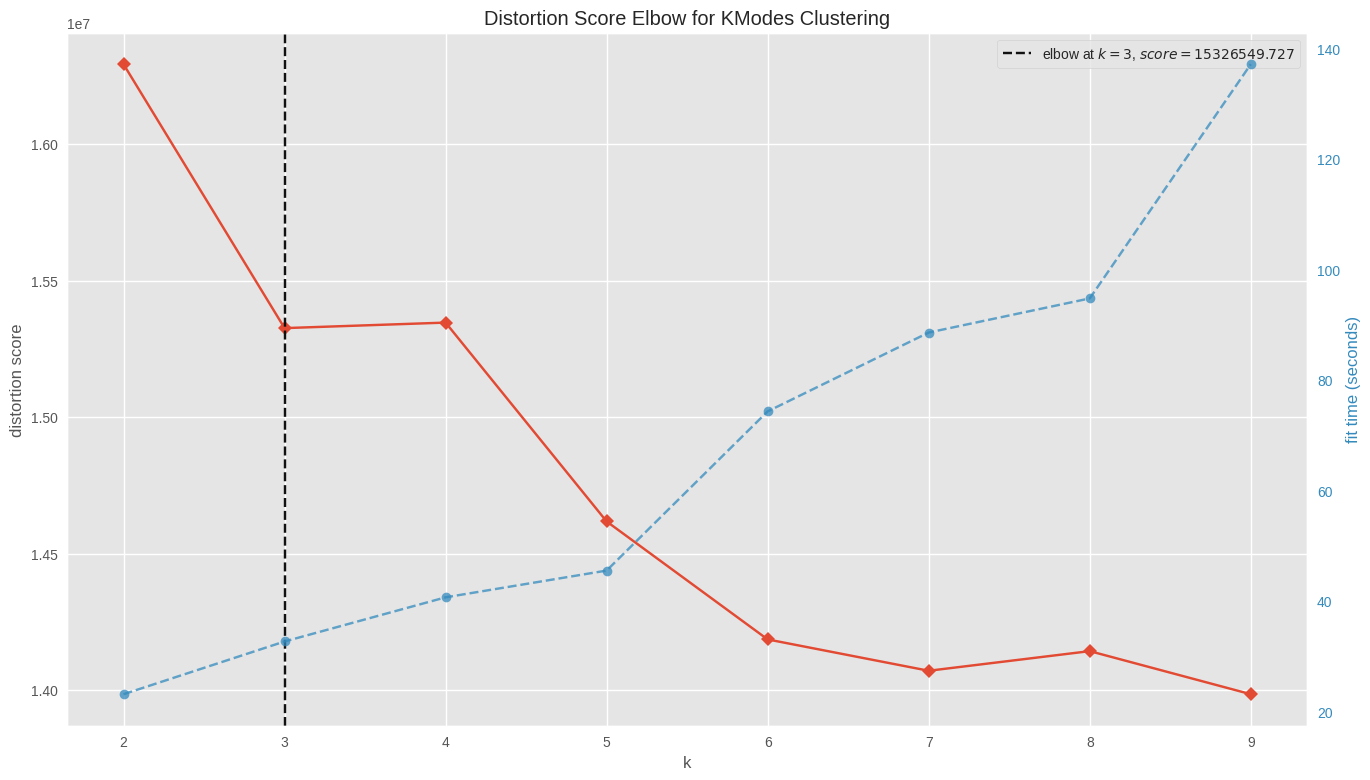

<Axes: title={'center': 'Distortion Score Elbow for KModes Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
model = KModes(init = 'Cao', n_init = 1, verbose=1, random_state=42)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
visualizer.fit(principal_df_articles_cluster)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

# **Pipeline**

In [ ]:
# Entrenamiento modelo k-means con el valor óptimo encontrado de k

k = 3  #Número de grupos que se escogió después del análisis previo.

modes_pipe = make_pipeline(
                KModes(
                    n_clusters   = k,            
                    init         = 'Cao',    
                    n_init = 1,
                    verbose=1, 
                    random_state=42)
)
modes_pipe

Pipeline(steps=[('kmodes',
                 KModes(n_clusters=3, n_init=1, random_state=42, verbose=1))])

In [ ]:
X = np.array(principal_df_articles_cluster)
X.shape

(105126, 6)

In [ ]:
#Hagamos el ajuste (i.e.: encontremos los centroides).
modes_pipe.fit(X)
modes_pipe.named_steps

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 323430.0


{'kmodes': KModes(n_clusters=3, n_init=1, random_state=42, verbose=1)}

# **Algoritmo K-modes**

In [ ]:
# Se extrae el modelo entrenado del pipeline
modelo_kmodes = modes_pipe.named_steps['kmodes']

In [ ]:
# Prediciendo los clusters
labels = modelo_kmodes.predict(X)
labels.shape

(105126,)

In [ ]:
#Revisemos los centroides de cada grupo.
centroides = modelo_kmodes.cluster_centroids_
centroides.shape

(3, 6)

In [ ]:
# Check the iteration of the clusters created
modelo_kmodes.n_iter_

1

In [ ]:
# Check the cost of the clusters created
modelo_kmodes.cost_

323430.0

## **Gráfica 3D** 

Debido a que se cuenta con mucha dimensionalidad, una gráfica 3D no aporta información adecuada

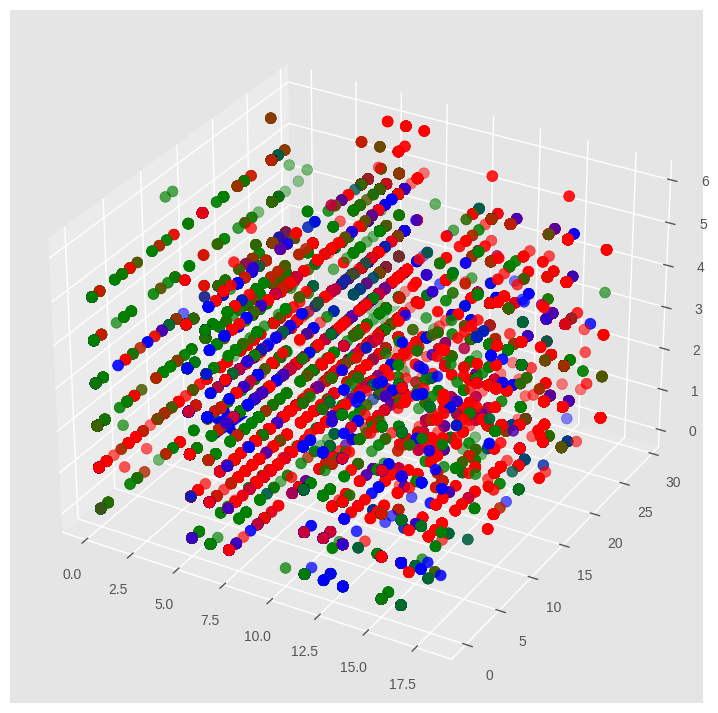

In [ ]:
from numpy.random.mtrand import randint

colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(centroides[:, 0], centroides[:, 1], centroides[:, 2], marker='*', c=colores, s=1000)
plt.show()

### **Agregar columna de clusters**

In [ ]:
df_articles_copy['Cluster No'] = modelo_kmodes.labels_
df_articles_copy.head()

,article_id,product_group_name,graphical_appearance_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,Cluster No
0,108775015,7,25,1,1,2,5,Jersey top with narrow shoulder straps.,0
1,108775044,7,25,3,1,2,5,Jersey top with narrow shoulder straps.,0
2,108775051,7,26,2,1,2,5,Jersey top with narrow shoulder straps.,0
3,110065001,16,25,1,1,2,18,"Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",0
4,110065002,16,25,3,1,2,18,"Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",0


#**Exploración del modelo**

In [ ]:
copy =  pd.DataFrame()
copy['article_id']=df_articles_copy['article_id'].values
copy['cluster'] = df_articles_copy['Cluster No'].values
copy['label'] = labels;
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['color']=colores
cantidadGrupo['cantidad']=copy.groupby('label').size()
cantidadGrupo

,color,cantidad
0,red,69016
1,green,23145
2,blue,12965


In [ ]:
#vemos las posiciones de los representantes del grupo en el array X, los articulos más cercano a cada centroid
closest, _ = pairwise_distances_argmin_min(modelo_kmodes.cluster_centroids_, X)
closest

array([  816, 86005,  1403])

In [ ]:
# Articulos que están más cerca a los centroids de cada grupo que podríamos decir que tienen atributos que representan a cada cluster
articles=df_articles_copy['article_id'].values
for row in closest:
    print(articles[row])

294008009
823879001
348330031


In [ ]:
df_articles = pd.read_csv('articles.csv',na_values='?')

In [ ]:
#Representante cluster 0 - red
df_articles[df_articles['article_id']==294008009]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
816,294008009,294008,Cora T-shirt,255,T-shirt,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy,Gently flared top in soft viscose jersey with short sleeves and a rounded hem.


In [ ]:
#Representante cluster 1 - green
df_articles[df_articles['article_id']==823879001]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
86419,823879001,823879,2-p Danceleggings,273,Leggings/Tights,Garment Lower body,1010016,Solid,51,Light Pink,1,Dusty Light,4,Pink,4314,Kids Dress-up/Football,J,"Children Accessories, Swimwear",4,Baby/Children,43,"Kids Accessories, Swimwear & D",1019,Accessories,Dance leggings in microfibre with an elasticated waist.


In [ ]:
#Representante cluster 2 - blue
df_articles[df_articles['article_id']==348330031]

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
1403,348330031,348330,Tanktop body Mixed 2p,256,Bodysuit,Garment Upper body,1010001,All over pattern,92,Green,3,Light,19,Green,6515,Baby basics,G,Baby Sizes 50-98,4,Baby/Children,44,Baby Essentials & Complements,1002,Jersey Basic,Sleeveless bodysuits in soft organic cotton jersey with press-studs at the crotch.


#**Recomendacion a clientes a partir del modelo**

Con el método **recommendations** se busca recomendar dado un usuario, 5 artículos de cada cluster diferente a los que peertenezcan los artículos que haya comprado anteriormente

In [ ]:
def recommendations(clientID):
  df_client = df_merged[df_merged['customer_id']==clientID]
  clusters = []
  df_recomended = pd.DataFrame()   
  articles = pd.DataFrame()   
  for i in df_articles.columns:
    df_recomended[i] = [] 
  for i in df_articles_copy.columns:
    articles[i] = [] 
  for index, transaction in df_client.iterrows():
    ar_id=transaction[1]
    row=df_articles_copy[df_articles_copy["article_id"]==ar_id]
    cluster=row["Cluster No"].values[0]
    clusters.append(cluster)
  unique_clusters = list(set(clusters))
  for cluster in unique_clusters:
    row = df_articles_copy[df_articles_copy["Cluster No"] == cluster].sample(5)
    articles=articles.append(row)
  for index, article in articles.iterrows():
    df_recomended = df_recomended.append(df_articles[df_articles['article_id']==article[0]], ignore_index=True)
  return df_recomended,df_client 

Se prueba con un cliente existente aleatorio

In [ ]:
customer = df_merged.sample(1)["customer_id"].values[0]
print(customer)

a328e221bec3f45b17971fe0ca7c5ace0d2e13d5193603289e1d96510be260ea


El método **purchasedArticles** permite obtener aquellos artículos que ha comprado el cliente, para comparar aquello que se la ha recomendado con lo que está en su historial de compras

In [ ]:
def purchasedArticles(df):
  df_purchased = pd.DataFrame()
  for i in df_articles.columns:
    df_purchased[i] = [] 
  for index, article in df.iterrows():
    df_purchased = df_purchased.append(df_articles[df_articles['article_id']==article[1]], ignore_index=True)
  return df_purchased  

In [ ]:
df_recomended, df_client = recommendations(customer)

<ipython-input-86-c8ecbac21c6b>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  articles=articles.append(row)
<ipython-input-86-c8ecbac21c6b>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_recomended = df_recomended.append(df_articles[df_articles['article_id']==article[0]], ignore_index=True)


In [ ]:
df_purchased = purchasedArticles(df_client)
df_purchased.head()

<ipython-input-88-d33e8e64b06a>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_purchased = df_purchased.append(df_articles[df_articles['article_id']==article[1]], ignore_index=True)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,700115001.0,700115.0,Blazer Dress,265.0,Dress,Garment Full body,1010016.0,Solid,9.0,Black,4.0,Dark,5.0,Black,5961.0,Dresses DS,D,Divided,2.0,Divided,58.0,Divided Selected,1013.0,Dresses Ladies,"Double-breasted dress in woven fabric with notch lapels, a V-neck, wrapover front, long sleeves and a concealed zip in one side. Unlined."
1,682771001.0,682771.0,Yuki shopper,66.0,Bag,Accessories,1010016.0,Solid,9.0,Black,4.0,Dark,5.0,Black,3209.0,Bags,C,Ladies Accessories,1.0,Ladieswear,65.0,Womens Big accessories,1019.0,Accessories,"Shopper in grained imitation leather with two handles at the top, a flap with a magnetic fastener and a zipped inner compartment. Imitation suede inside. Size 13x28x32 cm."
2,734050001.0,734050.0,Ronja,275.0,Skirt,Garment Lower body,1010004.0,Check,72.0,Blue,2.0,Medium Dusty,2.0,Blue,1422.0,Skirt,A,Ladieswear,1.0,Ladieswear,15.0,Womens Everyday Collection,1012.0,Skirts,"Short skirt in a checked weave with a wrapover front, fastener at the top, and concealed zip at the back. Lined."


In [ ]:
df_recomended.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,691474002.0,691474.0,Easy tencel shorts,274.0,Shorts,Garment Lower body,1010023.0,Denim,72.0,Blue,2.0,Medium Dusty,2.0,Blue,2031.0,Woven bottoms,A,Ladieswear,1.0,Ladieswear,8.0,Mama,1009.0,Trousers,"Shorts in soft, gently draping Tencel™ lyocell denim with a detachable tie belt at the waist, side pockets and fake back pockets. Soft jersey panel at the waist for optimum fit."
1,708740017.0,708740.0,MINERAL CREW,252.0,Sweater,Garment Upper body,1010026.0,Other structure,17.0,Yellowish Brown,2.0,Medium Dusty,13.0,Brown,5828.0,Jersey Fancy,F,Menswear,3.0,Menswear,20.0,Contemporary Smart,1005.0,Jersey Fancy,"Long-sleeved top in textured-knit jersey made from a cotton blend with ribbing around the neckline, cuffs and hem."
2,821406001.0,821406.0,Girlfriend Trash,272.0,Trousers,Garment Lower body,1010023.0,Denim,72.0,Blue,2.0,Medium Dusty,2.0,Blue,1722.0,Trouser,A,Ladieswear,1.0,Ladieswear,15.0,Womens Everyday Collection,1009.0,Trousers,"5-pocket, ankle-length jeans in washed, stretch cotton denim with hard-worn details in a slightly looser fit with a regular waist, zip fly and button and tapered legs with raw-edge hems. The cotton content of the jeans is partly recycled."
3,804666001.0,804666.0,Piper Strappy Push Body,283.0,Underwear body,Underwear,1010016.0,Solid,9.0,Black,4.0,Dark,5.0,Black,1338.0,Expressive Lingerie,B,Lingeries/Tights,1.0,Ladieswear,61.0,Womens Lingerie,1017.0,"Under-, Nightwear","Thong body in lace with crossover straps at the front and underwired, padded cups for a larger bust and fuller cleavage. Low cut at the back, adjustable shoulder straps, a hook-and-eye fastening at the back, a lined gusset with press-studs, and a string back."
4,814395001.0,814395.0,Michael Low SB,94.0,Sneakers,Shoes,1010016.0,Solid,10.0,White,3.0,Light,9.0,White,4211.0,Kids Boy Shoes,J,"Children Accessories, Swimwear",4.0,Baby/Children,42.0,Kids & Baby Shoes,1020.0,Shoes,Fabric trainers with a concealed elastic gore at the front and a loop at the back. Fabric linings and insoles and fluted rubber soles.


In [ ]:
from google.colab import files
df_articles_copy.to_csv('kmodesClusters.csv', encoding = 'utf-8-sig') 
files.download('kmodesClusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
df_articles.to_csv('articles.csv', encoding = 'utf-8-sig') 
files.download('articles.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
df_merged.to_csv('merged.csv', encoding = 'utf-8-sig') 
files.download('merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_merged.head()

,customer_id,article_id,product_group_name,graphical_appearance_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc
0,1ff8f7f7d9f3d109e59a8e7b6da7dd52ad34dbad8d5769086fb074eaf6bde253,812241008,5,0,1,1,2,1,"Short, straight-cut dress in woven fabric with a small collar, V-neck and gathered yoke at the back. Gathers at the shoulders and long balloon sleeves with buttoned cuffs. Unlined."
1,0120cd1ef4db7d1a08c78f4fa92278322f5398fda305dc79b5e2c01aa134e92a,812241008,5,0,1,1,2,1,"Short, straight-cut dress in woven fabric with a small collar, V-neck and gathered yoke at the back. Gathers at the shoulders and long balloon sleeves with buttoned cuffs. Unlined."
2,fe672a097be27126d6f26045ef2197d92d59445c38cd8df2b2a4acebd02649f1,812241008,5,0,1,1,2,1,"Short, straight-cut dress in woven fabric with a small collar, V-neck and gathered yoke at the back. Gathers at the shoulders and long balloon sleeves with buttoned cuffs. Unlined."
3,5023d370d518f8c5b8e626e5bbba3916a9dbb2a5411aeab27b35ee148d95a8e1,812241008,5,0,1,1,2,1,"Short, straight-cut dress in woven fabric with a small collar, V-neck and gathered yoke at the back. Gathers at the shoulders and long balloon sleeves with buttoned cuffs. Unlined."
4,b71cce8c5cc58115ae9d50eb719e273f07efc612469fad0346cbe265b21f8c21,812241008,5,0,1,1,2,1,"Short, straight-cut dress in woven fabric with a small collar, V-neck and gathered yoke at the back. Gathers at the shoulders and long balloon sleeves with buttoned cuffs. Unlined."


In [ ]:
df_articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort."


In [ ]:
df_articles_copy.head()

,article_id,product_group_name,graphical_appearance_name,perceived_colour_value_name,perceived_colour_master_name,index_group_name,garment_group_name,detail_desc,Cluster No
0,108775015,7,25,1,1,2,5,Jersey top with narrow shoulder straps.,0
1,108775044,7,25,3,1,2,5,Jersey top with narrow shoulder straps.,0
2,108775051,7,26,2,1,2,5,Jersey top with narrow shoulder straps.,0
3,110065001,16,25,1,1,2,18,"Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",0
4,110065002,16,25,3,1,2,18,"Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.",0
